In [2]:
import numpy as np
import os

def read_lammps_dump(filename):
    """Reads a LAMMPS trajectory file and extracts box dimensions and atomic positions."""
    with open(filename, "r") as f:
        lines = f.readlines()

    frames = []
    i = 0
    while i < len(lines):
        if "ITEM: TIMESTEP" in lines[i]:
            timestep = int(lines[i + 1].strip())
            i += 2
        elif "ITEM: BOX BOUNDS" in lines[i]:
            # Read box bounds
            x_bounds = list(map(float, lines[i + 1].strip().split()))
            y_bounds = list(map(float, lines[i + 2].strip().split()))
            z_bounds = list(map(float, lines[i + 3].strip().split()))
            i += 4
        elif "ITEM: ATOMS" in lines[i]:
            # Read atomic data
            atom_data = []
            headers = lines[i].strip().split()[2:]  # Extract column names
            i += 1
            while i < len(lines) and "ITEM:" not in lines[i]:
                atom_data.append(list(map(float, lines[i].strip().split())))
                i += 1

            atom_data = np.array(atom_data)
            frames.append({
                "timestep": timestep,
                "box": (x_bounds, y_bounds, z_bounds),
                "atoms": atom_data,
                "headers": headers,
            })
        else:
            i += 1

    return frames


def write_vasp_file(frame, filename, atom_type_map, updated_counts):
    """Writes a single frame to a VASP POSCAR/CONTCAR file."""
    x_bounds, y_bounds, z_bounds = frame["box"]
    atoms = frame["atoms"]
    headers = frame["headers"]

    # Extract lattice vectors from box bounds
    a = x_bounds[1] - x_bounds[0]
    b = y_bounds[1] - y_bounds[0]
    c = z_bounds[1] - z_bounds[0]
    lattice_vectors = np.array([
        [a, 0.0, 0.0],
        [0.0, b, 0.0],
        [0.0, 0.0, c],
    ])

    # Extract atom types and positions
    atom_types = atoms[:, headers.index("type")].astype(int)
    positions_cartesian = atoms[:, [headers.index("x"), headers.index("y"), headers.index("z")]]

    # Convert Cartesian coordinates to fractional
    inv_lattice = np.linalg.inv(lattice_vectors)
    positions_fractional = np.dot(positions_cartesian - [x_bounds[0], y_bounds[0], z_bounds[0]], inv_lattice)

    # Map numerical atom types to chemical symbols
    chemical_symbols = [atom_type_map[t] for t in atom_types]

    # Write VASP POSCAR/CONTCAR format with updated counts
    with open(filename, "w") as f:
        f.write(f"Generated from LAMMPS dump file\n")
        f.write(f"1.0\n")
        for vec in lattice_vectors:
            f.write(f"{vec[0]:.6f} {vec[1]:.6f} {vec[2]:.6f}\n")
        f.write(" ".join(updated_counts.keys()) + "\n")  # Chemical symbols
        f.write(" ".join(map(str, updated_counts.values())) + "\n")  # Updated counts
        f.write("Direct\n")
        
        for symbol in updated_counts.keys():
            count_to_write = updated_counts[symbol]
            symbol_positions = positions_fractional[np.array(chemical_symbols) == symbol]
            
            for pos in symbol_positions[:count_to_write]:
                f.write(f"{pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")


def convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts):
    """Converts all frames of a LAMMPS dump file to VASP POSCAR/CONTCAR files."""
    frames = read_lammps_dump(dump_file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, frame in enumerate(frames):
        filename = os.path.join(output_dir, f"CONTCAR{i+1}")
        write_vasp_file(frame, filename, atom_type_map, updated_counts)
        print(f"Saved: {filename}")


# Example usage
dump_file = "dump.nb"
output_dir = "vasp_files_300"

# Define the mapping of numerical atom types to chemical symbols
atom_type_map = {
    1: "Mg",   # Atom type 1 -> Magnesium
    2: "V",    # Atom type 2 -> Oxygen
    3: "O",    # Atom type 3 -> Vanadium
}

# Define the updated counts for each chemical symbol (e.g., O -> 60)
updated_counts = {
    "Mg": 12,
    "V": 24,
    "O": 60,
}

convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts)


Saved: vasp_files_300\CONTCAR1
Saved: vasp_files_300\CONTCAR2
Saved: vasp_files_300\CONTCAR3
Saved: vasp_files_300\CONTCAR4
Saved: vasp_files_300\CONTCAR5
Saved: vasp_files_300\CONTCAR6
Saved: vasp_files_300\CONTCAR7
Saved: vasp_files_300\CONTCAR8
Saved: vasp_files_300\CONTCAR9
Saved: vasp_files_300\CONTCAR10
Saved: vasp_files_300\CONTCAR11
Saved: vasp_files_300\CONTCAR12
Saved: vasp_files_300\CONTCAR13
Saved: vasp_files_300\CONTCAR14
Saved: vasp_files_300\CONTCAR15
Saved: vasp_files_300\CONTCAR16
Saved: vasp_files_300\CONTCAR17
Saved: vasp_files_300\CONTCAR18
Saved: vasp_files_300\CONTCAR19
Saved: vasp_files_300\CONTCAR20
Saved: vasp_files_300\CONTCAR21
Saved: vasp_files_300\CONTCAR22
Saved: vasp_files_300\CONTCAR23
Saved: vasp_files_300\CONTCAR24
Saved: vasp_files_300\CONTCAR25
Saved: vasp_files_300\CONTCAR26
Saved: vasp_files_300\CONTCAR27
Saved: vasp_files_300\CONTCAR28
Saved: vasp_files_300\CONTCAR29
Saved: vasp_files_300\CONTCAR30
Saved: vasp_files_300\CONTCAR31
Saved: vasp_files

In [3]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files_50ps"
vasp_dir = r"E:\2_4_6\300\vasp_files_300"


# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert all CONTCAR files to pymatgen Structures
structures = []
for contcar_file in contcar_files:
    # Read the VASP file using ASE
    atoms = read(contcar_file)
    
    # Extract data from ASE Atoms object
    species = atoms.get_chemical_symbols()  # Atomic species
    positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
    lattice = atoms.get_cell()              # Lattice vectors (simulation box)
    
    # Convert to pymatgen Structure object
    structure = Structure(lattice, species, positions)
    structures.append(structure)

    print(f"Loaded structure from: {contcar_file}")

# Print summary
print(f"Number of structures loaded: {len(structures)}")


Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR1
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR10
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR100
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR1000
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR1001
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR101
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR102
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR103
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR104
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR105
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR106
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR107
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR108
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR109
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR11
Loaded structure from: E:\2_4_6\300\vasp_files_300\CONTCAR110
Loaded str

In [4]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files"

# Define the output directory for filtered structures
#output_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\filtered_vasp_files_50ps"
output_dir = r"E:\2_4_6\300\fileterd_vasp_files_300K"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert every 10th CONTCAR file to pymatgen Structures and save to a new folder
structures = []
for i, contcar_file in enumerate(contcar_files):
    if i % 20== 0:  # Process every 10th structure
        # Read the VASP file using ASE
        atoms = read(contcar_file)
        
        # Extract data from ASE Atoms object
        species = atoms.get_chemical_symbols()  # Atomic species
        positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
        lattice = atoms.get_cell()              # Lattice vectors (simulation box)
        
        # Convert to pymatgen Structure object
        structure = Structure(lattice, species, positions)
        structures.append(structure)

        # Save the structure as a new CONTCAR file in the output directory
        output_file = os.path.join(output_dir, f"CONTCAR_{i+1}")
        structure.to(filename=output_file, fmt="poscar")  # Save as POSCAR/CONTCAR format
        
        print(f"Processed and saved structure from: {contcar_file} to {output_file}")

# Print summary of filtered structures
print(f"Number of structures saved: {len(structures)}")


Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR1 to E:\2_4_6\300\fileterd_vasp_files_300K\CONTCAR_1
Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR115 to E:\2_4_6\300\fileterd_vasp_files_300K\CONTCAR_21
Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR133 to E:\2_4_6\300\fileterd_vasp_files_300K\CONTCAR_41
Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR151 to E:\2_4_6\300\fileterd_vasp_files_300K\CONTCAR_61
Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR17 to E:\2_4_6\300\fileterd_vasp_files_300K\CONTCAR_81
Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR188 to E:\2_4_6\300\fileterd_vasp_files_300K\CONTCAR_101
Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR205 to E:\2_4_6\300\fileterd_vasp_files_300K\CONTCAR_121
Processed and saved structure from: E:\2_4_6\300\vasp_files_300\CONTCAR223 to E:\2_4_6\300\fileterd_vasp_files_30

In [5]:
from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer

# Perform diffusion analysis on the loaded structures
diff_analyzer = DiffusionAnalyzer.from_structures(
    structures=structures,  # Your list of pymatgen Structure objects
    specie="Mg",            # The species for which you want to analyze diffusion
    temperature=300,        # Temperature in Kelvin
    time_step=2,            # Time step between frames in femtoseconds
    step_skip=130000,         # Skip every 1000 steps for smoother analysis
    smoothed="constant",    # Smoothing method (can also be "max")
    avg_nsteps=34         # Number of steps for averaging (smaller window for finer resolution)
)

# # Print diffusivity and other properties
# print(f"Diffusivity: {diff_analyzer.diffusivity} cm^2/s")
# print(f"Mean squared displacement (MSD):\n{diff_analyzer.msd}")
# print(f"Vacancy corrected diffusivity: {diff_analyzer.vacancy_corrected_diffusivity} cm^2/s")


In [6]:

#diff_calc.plot_msd(mode='default')
diff_analyzer.export_msdt("md_50ps")
import os
import pandas as pd
msd_md = pd.read_table("md_50ps", delimiter=' ')
print(msd_md)

          #           t        MSD       MSD_a       MSD_b       MSD_c  MSCD
0         0    0.000000   0.000000    0.000000    0.000000    0.000000   NaN
1    260000   59.225922  11.632570   22.186867   25.406485   70.210621   NaN
2    520000   89.459665  17.579679   35.290246   36.589740  125.061640   NaN
3    780000  123.980739  23.872558   50.076506   50.031674  195.042555   NaN
4   1040000  159.720854  31.236066   63.523776   64.961012  262.217344   NaN
5   1300000  189.133617  37.377654   75.679836   76.076128  334.252534   NaN
6   1560000  223.818675  47.192546   86.152781   90.473348  432.113959   NaN
7   1820000  249.805036  55.131167   94.301307  100.372562  482.708561   NaN
8   2080000  274.007890  62.731307  103.798066  107.478516  548.639697   NaN
9   2340000  299.736196  69.069895  112.893359  117.772943  605.266889   NaN
10  2600000  321.281803  74.359457  119.578629  127.343717  640.654533   NaN
11  2860000  340.837902  77.897258  123.420580  139.520064  663.392553   NaN

<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DEBS\AppData\Local\Temp\ipykernel_9672\2782865488.py:69: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)


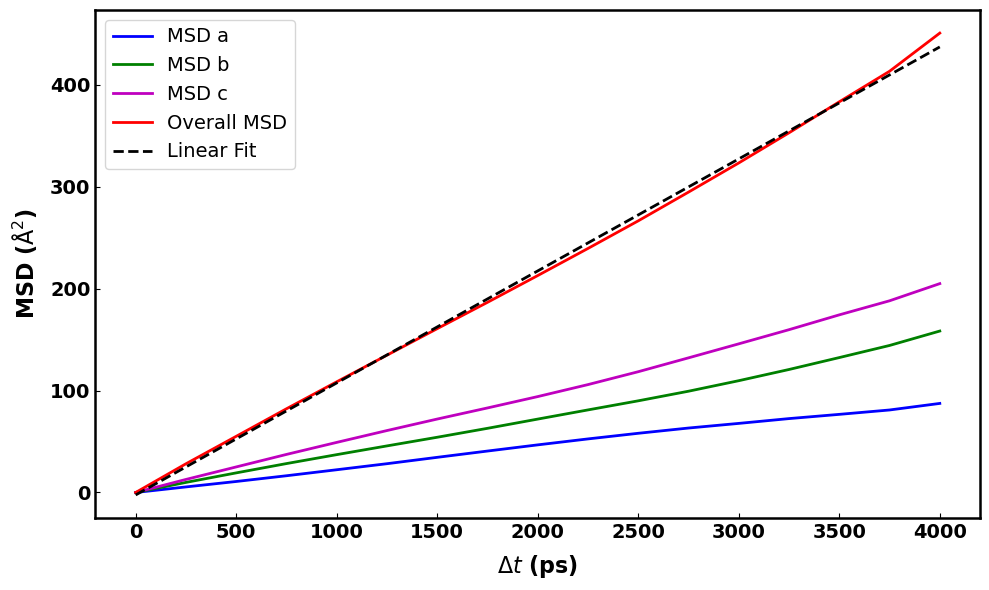

Diffusion Coefficient (Å^2/ps): 0.018323
Diffusion Coefficient (cm^2/s): 1.832291e-06


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# MSD series
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 4251, 250)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with the origin point (0, 0)
MSD_a_averages = [0]  # Start with MSD = 0 at delta_t = 0
MSD_b_averages = [0]
MSD_c_averages = [0]
MSD_t_averages = [0]

# Calculate MSD for each delta_t
for delta_t in delta_t_steps:
    msd_a_values = []  # To store MSD for each interval in msd_a
    msd_b_values = []  # To store MSD for each interval in msd_b
    msd_c_values = []  # To store MSD for each interval in msd_c
    msd_t_values = []  # To store MSD for each interval in msd_t

    # Loop through valid time windows based on delta_t
    for start_idx in range(len(msd_a) - delta_t // 250):  # 200 ps corresponds to a step size of 1 in your data
        end_idx = start_idx + delta_t // 250  # Calculate the index for delta_t

        # Ensure the indices are valid
        if end_idx < len(msd_a):
            # Calculate MSD for each series
            msd_a_values.append(msd_a.iloc[end_idx] - msd_a.iloc[start_idx])
            msd_b_values.append(msd_b.iloc[end_idx] - msd_b.iloc[start_idx])
            msd_c_values.append(msd_c.iloc[end_idx] - msd_c.iloc[start_idx])
            msd_t_values.append(msd_t.iloc[end_idx] - msd_t.iloc[start_idx])

    # Calculate the average MSD for this delta_t if valid values are found
    if msd_a_values:
        MSD_a_averages.append(np.mean(msd_a_values))
        MSD_b_averages.append(np.mean(msd_b_values))
        MSD_c_averages.append(np.mean(msd_c_values))
        MSD_t_averages.append(np.mean(msd_t_values))
        delta_t_values.append(delta_t)

# Plot MSD vs Delta t
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MSD data with continuous lines (no markers)
ax.plot(delta_t_values, MSD_a_averages, '-', label='MSD a', linewidth=2, color='b')
ax.plot(delta_t_values, MSD_b_averages, '-', label='MSD b', linewidth=2, color='g')
ax.plot(delta_t_values, MSD_c_averages, '-', label='MSD c', linewidth=2, color='m')
ax.plot(delta_t_values, MSD_t_averages, '-', label='Overall MSD', linewidth=2, color='r')

# Add a linear regression line for the overall MSD
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_t_averages)
r_squared = r_value**2
ax.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit', color='black', linewidth=2)

# Axis labels and legend
ax.set_xlabel(r'$\Delta t$ (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(loc="upper left", fontsize=14)

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Show the plot
plt.tight_layout()

# Save the figure as PDF
#plt.savefig("msd_vs_delta_t_all_series_300_continuous.pdf", format='pdf')
#plt.savefig("msd_vs_delta_t_all_series_300_continuous.tif", format='tif')

# Display the plot
plt.show()

# Print the calculated diffusivity
print(f"Diffusion Coefficient (Å^2/ps): {slope / 6:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {slope / 6 * 1e-4:.6e}")


In [ ]:
# import pandas as pd

# # Create a DataFrame with Delta t and Overall MSD
# df = pd.DataFrame({
#     'Delta_t (ps)': delta_t_values,
#     'Overall MSD (Å²)': MSD_t_averages
# })

# # Save to Excel
# df.to_excel("300_msd_246_4000ps.xlsx", index=False)

# print("Data saved to 1000_msd_4000ps.xlsx successfully!")


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy import stats

# # Assuming msd_dft is already loaded as a DataFrame
# time_fs = msd_md['#']
# time = time_fs / 1000  # Convert time to ps

# # Perform cumulative sum with a step of 10
# msd_a = msd_md['MSD']
# msd_b = msd_md['MSD_a']
# msd_c = msd_md['MSD_b']
# msd_t = msd_md['t']

# # Filter the data to include only up to 40,000 ps
# max_time_ps = 40000
# valid_indices = time <= max_time_ps
# time_filtered = time[valid_indices]
# msd_a_filtered = msd_a[valid_indices]
# msd_b_filtered = msd_b[valid_indices]
# msd_c_filtered = msd_c[valid_indices]
# msd_t_filtered = msd_t[valid_indices]

# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = stats.linregress(time_filtered, msd_t_filtered)

# # Calculate diffusivity
# diff_coeff_ang = slope / 6  # Diffusion coefficient in Å^2/ps
# diff_coeff_cm = diff_coeff_ang * 1e-4  # Convert to cm^2/s

# # Calculate R^2 score
# r_squared = r_value**2

# # Plotting
# legend_properties = {'weight': 'bold', 'size': 14}
# fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(time_filtered, msd_a_filtered, linewidth=4, linestyle='-', color='b', label='a')
# ax.plot(time_filtered, msd_b_filtered, linewidth=4, linestyle='dashdot', color='g', label='b')
# ax.plot(time_filtered, msd_c_filtered, linewidth=4, linestyle='--', color='m', label='c')
# ax.plot(time_filtered, msd_t_filtered, linewidth=4, linestyle='dotted', color='r', label='overall')
# ax.plot(time_filtered, intercept + slope * time_filtered, color='k', label='Linear Fit', linewidth=1)

# # Set x-axis limit to 40,000 ps
# plt.xlim(0, 4000)
# #plt.ylim(0, 1100)

# # Axis labels and legend
# ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
# ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
# ax.legend(prop=legend_properties, loc="upper left", edgecolor='k')

# # Adjust axis line widths
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(1.8)

# # Set ticks and styles
# plt.xticks(weight='bold', fontsize=14)
# plt.yticks(weight='bold', fontsize=14)
# plt.tick_params(direction='in')

# # Show the plot

# plt.tight_layout()
# plt.savefig("nonlinear_tif_300_246.tif", dpi=300, format='tiff', bbox_inches='tight')
# plt.show()


# # Print the calculated diffusivity and R^2 score
# print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
# print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")
# print(f"R^2 Score: {r_squared:.4f}")


In [8]:
diff_analyzer.get_summary_dict(include_msd_t=False, include_mscd_t=False)

{'D': 1.7297773631594983e-06,
 'D_sigma': 5.327139311330596e-08,
 'D_charge': 3.74559411426213e-06,
 'D_charge_sigma': 9.572292220239827e-08,
 'S': 58.45082364035104,
 'S_sigma': 1.800091081232716,
 'S_charge': 126.56719047426068,
 'D_components': [1.0915380491677023e-06,
  1.767847505184405e-06,
  2.3299465351263873e-06],
 'S_components': [36.88410969380413, 59.73724997755116, 78.73111124969783],
 'D_components_sigma': [6.313591279473946e-08,
  8.60087681323066e-08,
  4.464328101053862e-08],
 'S_components_sigma': [2.1334225911000213,
  2.906318145152964,
  1.5085389603592678],
 'specie': 'Mg',
 'step_skip': 130000,
 'time_step': 2,
 'temperature': 300,
 'max_framework_displacement': 91.09611904084208,
 'Haven_ratio': 0.46181655309981684}

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# Extract MSD components
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Filter the data to include only up to 40,000 ps
max_time_ps = 40000
valid_indices = time <= max_time_ps
time_filtered = time[valid_indices]
msd_a_filtered = msd_a[valid_indices]
msd_b_filtered = msd_b[valid_indices]
msd_c_filtered = msd_c[valid_indices]
msd_t_filtered = msd_t[valid_indices]

# Perform linear regression with forced intercept at 0
slope, _, _, _ = np.linalg.lstsq(time_filtered[:, np.newaxis], msd_t_filtered, rcond=None)

# Calculate diffusivity
diff_coeff_ang = slope[0] / 6  # Diffusion coefficient in Å^2/ps
diff_coeff_cm = diff_coeff_ang * 1e-4  # Convert to cm^2/s

# Compute R^2 score manually
msd_pred = slope[0] * time_filtered  # Predicted values using y = slope * x
ss_total = np.sum((msd_t_filtered - np.mean(msd_t_filtered))**2)
ss_residual = np.sum((msd_t_filtered - msd_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Plotting
legend_properties = {'weight': 'bold', 'size': 14}
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(time_filtered, msd_a_filtered, linewidth=4, linestyle='-', color='b', label='a')
ax.plot(time_filtered, msd_b_filtered, linewidth=4, linestyle='dashdot', color='g', label='b')
ax.plot(time_filtered, msd_c_filtered, linewidth=4, linestyle='--', color='m', label='c')
ax.plot(time_filtered, msd_t_filtered, linewidth=4, linestyle='dotted', color='r', label='overall')

# Plot linear fit starting from (0,0)
ax.plot(time_filtered, slope[0] * time_filtered, color='k', linestyle='-', linewidth=1, label='Linear Fit')

# Set x-axis limit
plt.xlim(0, 4000)

# Axis labels and legend
ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(prop=legend_properties, loc="upper left", edgecolor='k')

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Save the figure
plt.tight_layout()
#plt.savefig("nonlinear_tif_300_246.tif", dpi=300, format='tiff', bbox_inches='tight')
plt.show()

# Print results
print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")
print(f"R^2 Score: {r_squared:.4f}")


<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DEBS\AppData\Local\Temp\ipykernel_9672\1383431419.py:55: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
C:\Users\DEBS\AppData\Local\Temp\ipykernel_9672\1383431419.py:55: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# Extract MSD components
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Filter the data to include only up to 40,000 ps
max_time_ps = 40000
valid_indices = time <= max_time_ps
time_filtered = time[valid_indices].to_numpy()  # Convert to NumPy array
msd_a_filtered = msd_a[valid_indices].to_numpy()
msd_b_filtered = msd_b[valid_indices].to_numpy()
msd_c_filtered = msd_c[valid_indices].to_numpy()
msd_t_filtered = msd_t[valid_indices].to_numpy()

# Perform linear regression with forced intercept at 0
slope, _, _, _ = np.linalg.lstsq(time_filtered.reshape(-1, 1), msd_t_filtered, rcond=None)

# Calculate diffusivity
diff_coeff_ang = slope[0] / 6  # Diffusion coefficient in Å^2/ps
diff_coeff_cm = diff_coeff_ang * 1e-4  # Convert to cm^2/s

# Compute R^2 score manually
msd_pred = slope[0] * time_filtered  # Predicted values using y = slope * x
ss_total = np.sum((msd_t_filtered - np.mean(msd_t_filtered))**2)
ss_residual = np.sum((msd_t_filtered - msd_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Plotting
legend_properties = {'weight': 'bold', 'size': 14}
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(time_filtered, msd_a_filtered, linewidth=4, linestyle='-', color='b', label='a')
ax.plot(time_filtered, msd_b_filtered, linewidth=4, linestyle='dashdot', color='g', label='b')
ax.plot(time_filtered, msd_c_filtered, linewidth=4, linestyle='--', color='m', label='c')
ax.plot(time_filtered, msd_t_filtered, linewidth=4, linestyle='dotted', color='r', label='overall')

# Plot linear fit starting from (0,0)
ax.plot(time_filtered, slope[0] * time_filtered, color='k', linestyle='-', linewidth=1, label='Linear Fit')

# Set x-axis limit
plt.xlim(0, 4000)

# Axis labels and legend
ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(prop=legend_properties, loc="upper left", edgecolor='k')

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Save the figure
plt.tight_layout()
plt.savefig("nonlinear_tif_300_246.tif", dpi=300, format='tiff', bbox_inches='tight')
plt.show()

# Print results
print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")
print(f"R^2 Score: {r_squared:.4f}")


<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DEBS\AppData\Local\Temp\ipykernel_9672\2794928560.py:47: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)


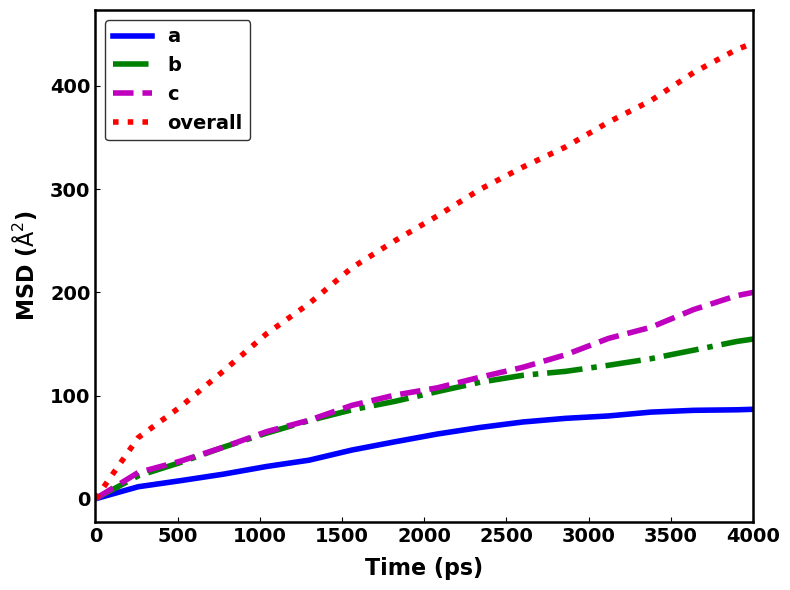

Diffusion Coefficient (Å^2/ps): 0.017298
Diffusion Coefficient (cm^2/s): 1.729777e-06
R^2 Score: 0.9860


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# Extract MSD components
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Filter the data to include only up to 40,000 ps
max_time_ps = 40000
valid_indices = time <= max_time_ps
time_filtered = time[valid_indices].to_numpy()  # Convert to NumPy array
msd_a_filtered = msd_a[valid_indices].to_numpy()
msd_b_filtered = msd_b[valid_indices].to_numpy()
msd_c_filtered = msd_c[valid_indices].to_numpy()
msd_t_filtered = msd_t[valid_indices].to_numpy()

# Calculate diffusivity using linear regression
slope, intercept, r_value, _, _ = stats.linregress(time_filtered, msd_t_filtered)
diff_coeff_ang = slope / 6  # Diffusion coefficient in Å^2/ps
diff_coeff_cm = diff_coeff_ang * 1e-4  # Convert to cm^2/s
r_squared = r_value**2

# Plotting
legend_properties = {'weight': 'bold', 'size': 14}
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(time_filtered, msd_a_filtered, linewidth=4, linestyle='-', color='b', label='a')
ax.plot(time_filtered, msd_b_filtered, linewidth=4, linestyle='dashdot', color='g', label='b')
ax.plot(time_filtered, msd_c_filtered, linewidth=4, linestyle='--', color='m', label='c')
ax.plot(time_filtered, msd_t_filtered, linewidth=4, linestyle='dotted', color='r', label='overall')

# No linear fit plot

# Set x-axis limit
plt.xlim(0, 4000)

# Axis labels and legend
ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(prop=legend_properties, loc="upper left", edgecolor='k')

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Save the figure
plt.tight_layout()
#plt.savefig("nonlinear_tif_300_246.tif", dpi=300, format='tiff', bbox_inches='tight')
plt.show()

# Print results
print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")
print(f"R^2 Score: {r_squared:.4f}")


In [11]:
from pymatgen.analysis.diffusion.aimd.van_hove import VanHoveAnalysis

In [28]:

vh_analysis = VanHoveAnalysis(
    diffusion_analyzer=diff_analyzer,
    avg_nsteps=2,
    ngrid=101,
    rmax=12.0,
    step_skip=1,  # Use every timestep
    sigma=0.4,
    species=["Mg"]
)


<Axes: xlabel='Time (ps)', ylabel='$r$ ($\\AA$)'>

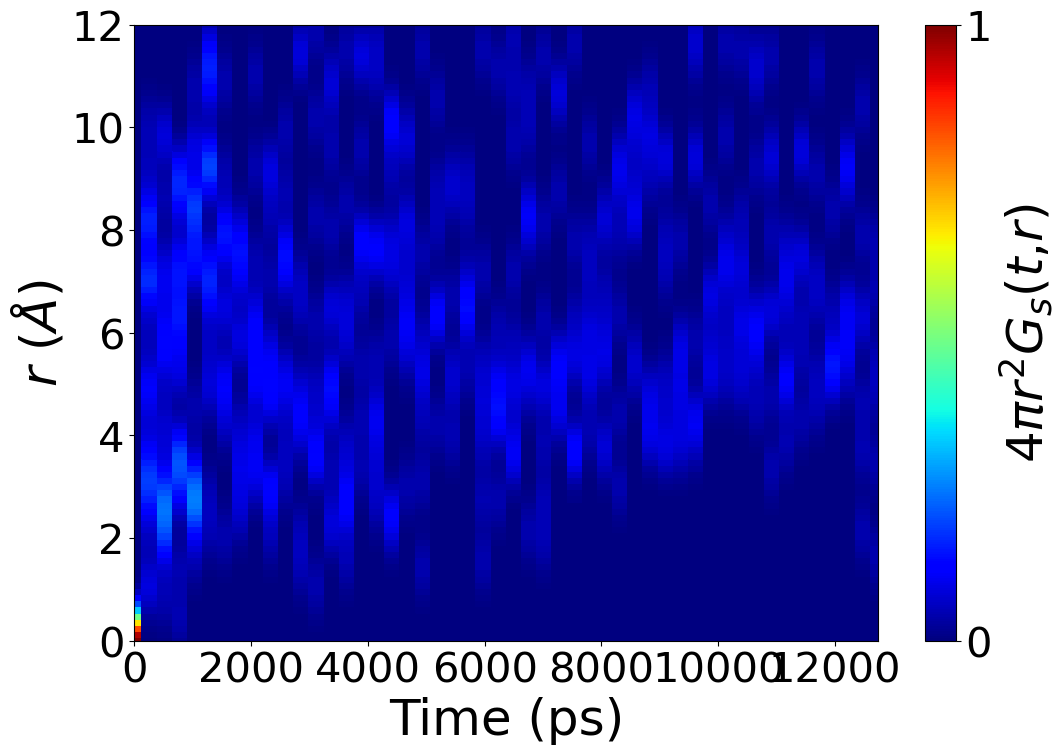

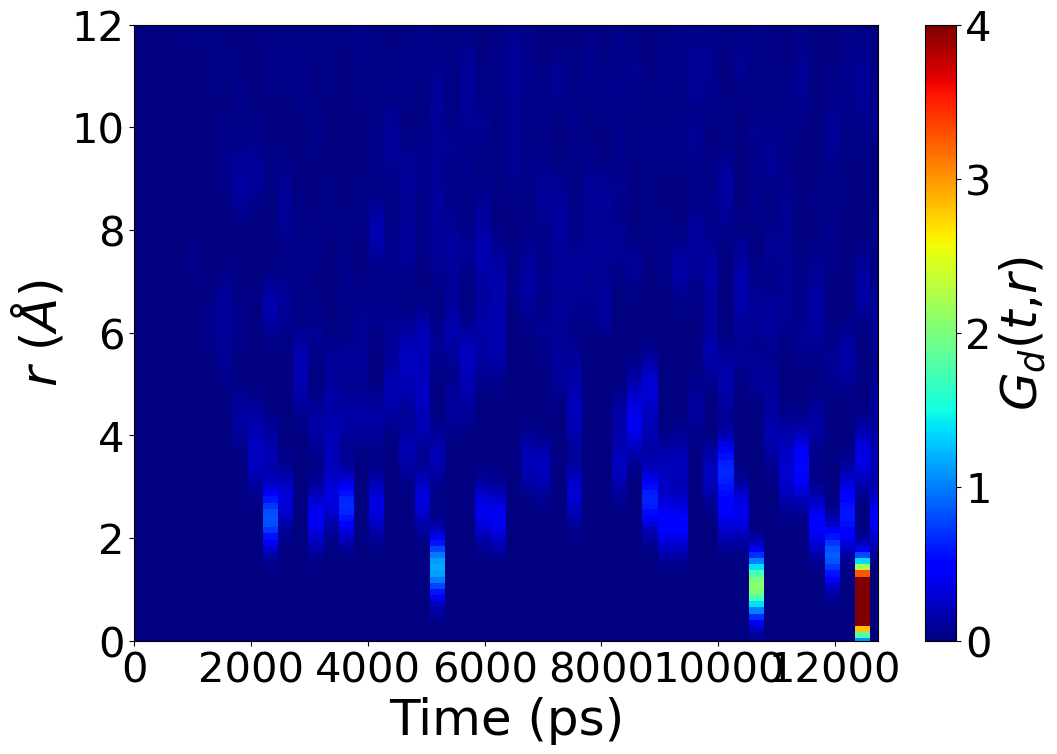

In [29]:
# Plot self-part of Van Hove function Gs(r,t)
vh_analysis.get_3d_plot(mode="self")

# Plot distinct-part of Van Hove function Gd(r,t)
vh_analysis.get_3d_plot(mode="distinct")


In [30]:
vh_analysis.get_3d_plot(mode="self", t_max=100)  # Example: Restrict time to 100 fs


TypeError: VanHoveAnalysis.get_3d_plot() got an unexpected keyword argument 't_max'

<Axes: xlabel='$r$ ($\\AA$)', ylabel='$G_d$($t$,$r$)'>

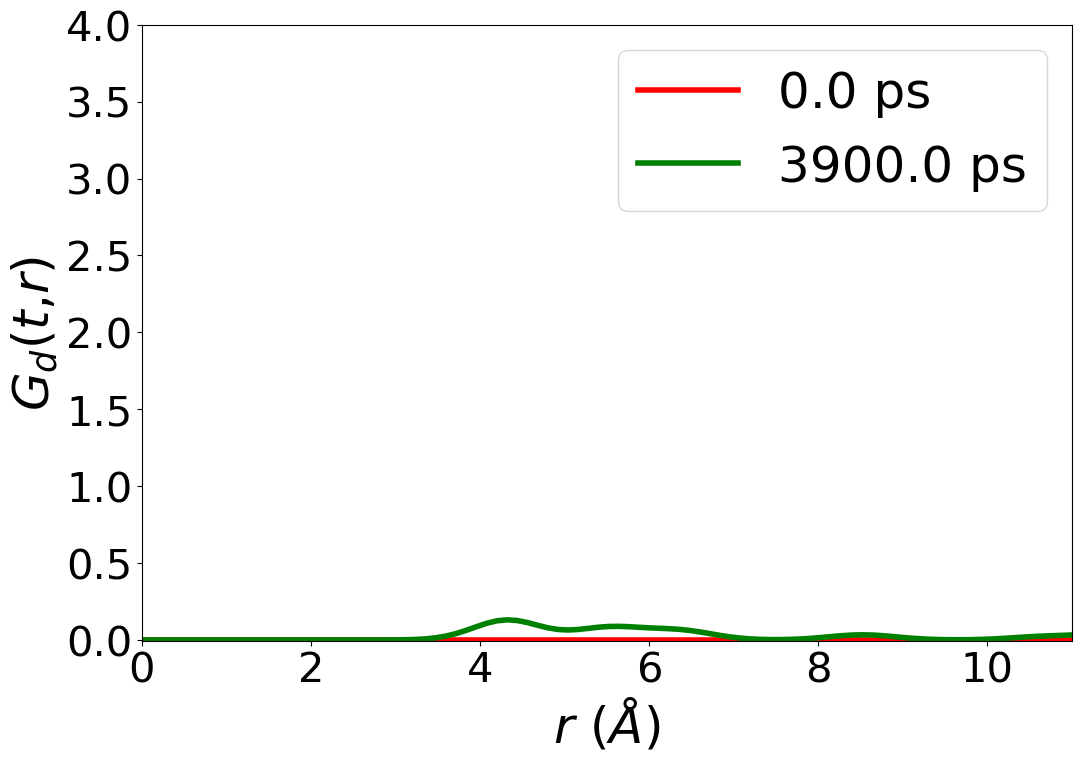

In [41]:
vh_analysis.get_1d_plot(times=[5.0, 4000.0], colors=["r", "g"], mode="distinct")

In [34]:
vhfunc.get_1d_plot(times=[0.0, 1.0], colors=["r", "g"], mode="distinct")

NameError: name 'vhfunc' is not defined

<Axes: xlabel='$r$ ($\\AA$)', ylabel='$G_d$($t$,$r$)'>

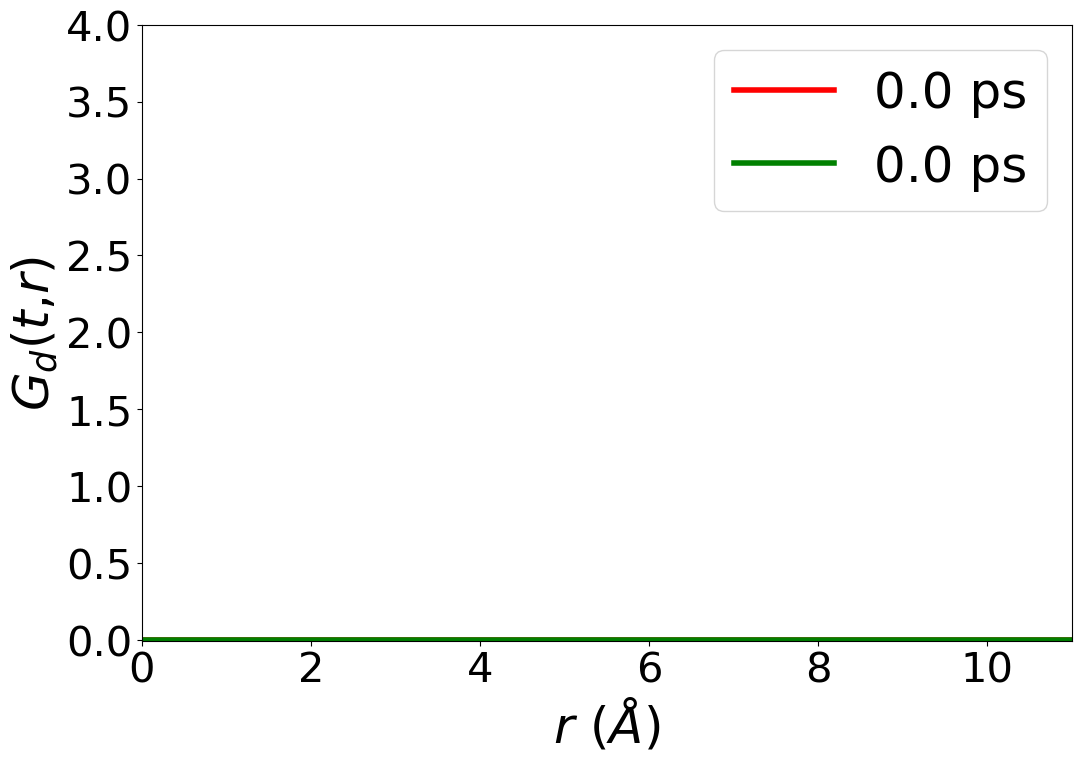

In [36]:
vh_analysis.get_1d_plot(times=[0.0, 100.0], colors=["r", "g"], mode="distinct")